In [13]:
import pandas as pd
import numpy as np
import googlemaps
from dotenv import load_dotenv
import os
import requests 
import time
load_dotenv()


True

In [2]:
df = pd.read_csv('../data/silver_dataset.csv', index_col = 0)

In [3]:
df.head()

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,transaction,furnishing_status,bathroom_count,property_type,latitude,longitude
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,Resale,Semi,9.0,apartment,13.009859,77.553298
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,Resale,Semi,3.0,apartment,12.994880,77.556237
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,New Property,Unfurnished,2.0,apartment,12.899052,77.678117
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,New Property,Unfurnished,2.0,apartment,12.898554,77.565011
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,Resale,Semi,2.0,apartment,12.746104,77.487602


In [4]:
df.shape

(4004, 13)

## Getting the sublocality using GMaps API.

I observed that this feature is too fine grained, makes the number of unique values too high and also gives null values.

In [14]:

GMAPS_API_KEY = os.getenv('GMAPS_API_KEY')

def get_sublocality(lat, lon):
    """Fetches sublocality_level_1 using Google Maps Reverse Geocoding."""
    url = f"https://maps.googleapis.com/maps/api/geocode/json?latlng={lat},{lon}&key={GMAPS_API_KEY}"
    try:
        response = requests.get(url)
        data = response.json()

        if data["status"] == "OK":
            for component in data["results"][0]["address_components"]:
                if "sublocality_level_1" in component["types"]:
                    return component["long_name"]
        return None  # If no sublocality found
    except Exception as e:
        print(f"Error fetching for ({lat}, {lon}): {e}")
        return None

def add_sublocality(df, lat_col="latitude", lon_col="longitude"):
    """Adds 'sublocality' column to the DataFrame."""
    sublocalities = []
    total = len(df)
    for i, row in df.iterrows():
        lat, lon = row[lat_col], row[lon_col]
        sublocality = get_sublocality(lat, lon)
        sublocalities.append(sublocality)
        if (i + 1) % 50 == 0 or i == total - 1:
            print(f"Processed {i+1}/{total} rows")
        time.sleep(0.1)  # short delay to avoid rate limit
    df["sublocality"] = sublocalities
    return df



In [16]:
temp = add_sublocality(df.iloc[:100], lat_col="latitude", lon_col="longitude")

Processed 50/100 rows
Processed 100/100 rows


/var/folders/7g/4gs_xv6x37718rlznpykmvpw0000gn/T/ipykernel_53101/1839439295.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sublocality"] = sublocalities


In [21]:
temp['sublocality'].isnull().sum()

21

In [23]:
len(temp['sublocality'].unique())

45

## Getting the locality using GMaps API

	•	Fewer unique values (easier for ML algorithms).
	•	Very few nulls.
	•	Still geographically meaningful — captures local property trends.

In [30]:
def get_locality(lat, lon, gmaps_client):
    """Return best locality name from Google Maps reverse geocode result."""
    try:
        result = gmaps_client.reverse_geocode((lat, lon), language='en')
        if not result:
            return None

        # Check top result’s address components
        for res in result:
            for comp in res.get('address_components', []):
                types = comp.get('types', [])
                if 'sublocality_level_1' in types:
                    return comp['long_name']
                elif 'sublocality' in types:
                    return comp['long_name']
                elif 'neighborhood' in types or 'neighbourhood' in types:
                    return comp['long_name']
                elif 'locality' in types:
                    return comp['long_name']
        # fallback
        return result[0].get('formatted_address', None)
    except Exception as e:
        print(f"Error at ({lat}, {lon}): {e}")
        return None


def add_locality(df, api_key, lat_col='latitude', lon_col='longitude', delay=0.2):
    """Add a 'locality' column using Google Maps reverse geocoding."""
    gmaps = googlemaps.Client(key=api_key)
    localities = []

    for i, row in df.iterrows():
        lat, lon = row[lat_col], row[lon_col]
        if pd.isna(lat) or pd.isna(lon):
            localities.append(None)
            continue

        locality = get_locality(lat, lon, gmaps)
        localities.append(locality)

        if i % 50 == 0:
            print(f"Processed {i+1}/{len(df)} rows")
        time.sleep(delay)  # prevent hitting rate limits

    df = df.copy()
    df['locality'] = localities
    return df

In [31]:
GMAPS_API_KEY = os.getenv('GMAPS_API_KEY')

# Run enrichment
temp = add_locality(df.iloc[:100], api_key=GMAPS_API_KEY)
print(temp[['property_id', 'latitude', 'longitude', 'locality']])

Processed 1/100 rows
Processed 51/100 rows
    property_id   latitude  longitude           locality
0             1  13.009859  77.553298        Rajajinagar
1             2  12.994880  77.556237      Prakash Nagar
2             3  12.899052  77.678117      Kasavanahalli
3             4  12.898554  77.565011       Vikram Nagar
4             5  12.746104  77.487602         Kanakapura
..          ...        ...        ...                ...
95           96  12.900521  77.710237         Carmelaram
96           97  13.058203  77.621025  Manyata Residency
97           98  13.066403  77.576420   Prakruthi Layout
98           99  13.105570  77.643630          Bengaluru
99          100  12.782255  77.645230          1st Phase

[100 rows x 4 columns]


In [32]:
temp['locality'].nunique()

62

In [33]:
temp['locality'].value_counts()

locality
Kaikondrahalli    9
Bengaluru         9
Palm Meadows      6
Carmelaram        5
Gunjur Palya      4
                 ..
Prakash Nagar     1
Billapura         1
Kodathi           1
Chikkakannalli    1
1st Phase         1
Name: count, Length: 62, dtype: int64

In [34]:
df = add_locality(df, api_key=GMAPS_API_KEY)


Processed 1/4004 rows
Processed 51/4004 rows
Processed 101/4004 rows
Processed 151/4004 rows
Processed 201/4004 rows
Processed 251/4004 rows
Processed 301/4004 rows
Processed 351/4004 rows
Processed 401/4004 rows
Processed 451/4004 rows
Processed 501/4004 rows
Processed 551/4004 rows
Processed 601/4004 rows
Processed 651/4004 rows
Processed 701/4004 rows
Processed 751/4004 rows
Processed 801/4004 rows
Processed 851/4004 rows
Processed 901/4004 rows
Processed 951/4004 rows
Processed 1051/4004 rows
Processed 1101/4004 rows
Processed 1151/4004 rows
Processed 1201/4004 rows
Processed 1251/4004 rows
Processed 1301/4004 rows
Processed 1351/4004 rows
Processed 1401/4004 rows
Processed 1451/4004 rows
Processed 1501/4004 rows
Processed 1551/4004 rows
Processed 1601/4004 rows
Processed 1651/4004 rows
Processed 1701/4004 rows
Processed 1751/4004 rows
Processed 1801/4004 rows
Processed 1851/4004 rows
Processed 1901/4004 rows
Processed 1951/4004 rows
Processed 2051/4004 rows
Processed 2101/4004 row

In [37]:
df['locality'].nunique()

919

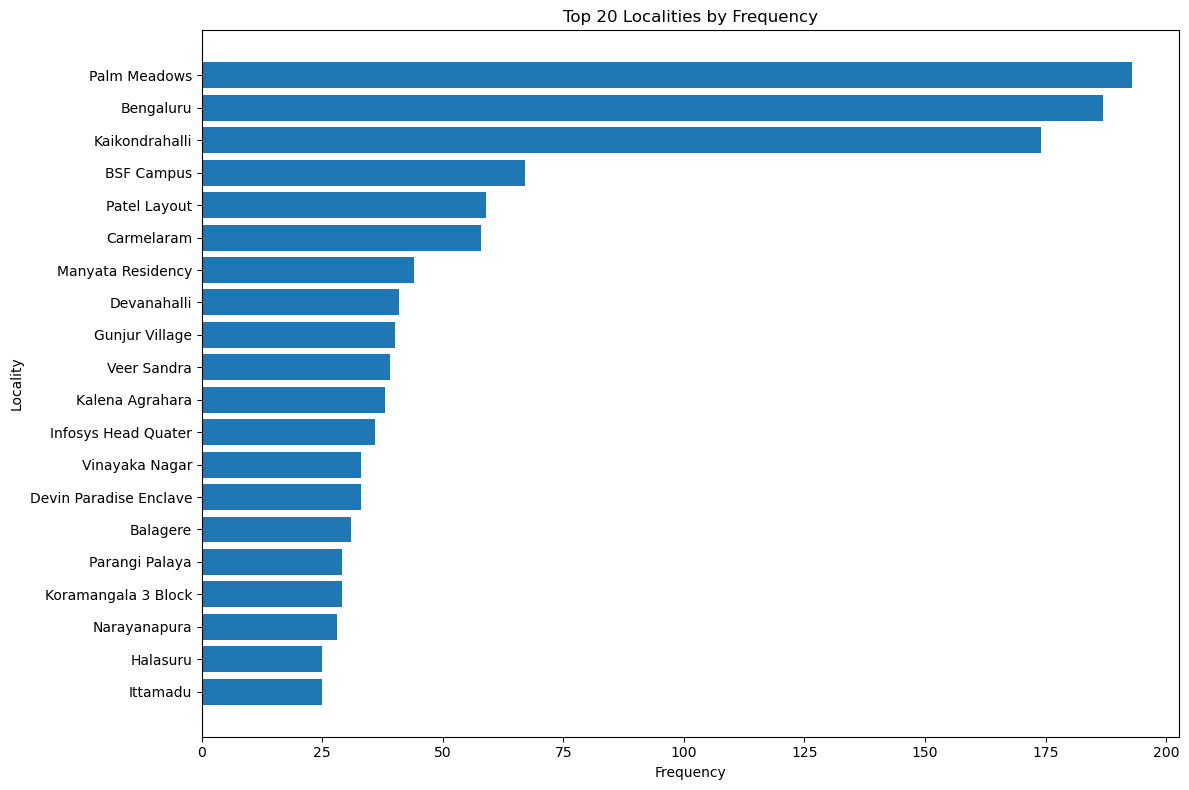

Total unique localities: 38
Most common locality: Palm Meadows (193 properties)


In [36]:
import matplotlib.pyplot as plt

# Create a visualization of locality frequency
plt.figure(figsize=(12, 8))
locality_counts = df['locality'].value_counts()

# Plot the top 20 localities for better readability
top_20_localities = locality_counts.head(20)
plt.barh(range(len(top_20_localities)), top_20_localities.values)
plt.yticks(range(len(top_20_localities)), top_20_localities.index)
plt.xlabel('Frequency')
plt.ylabel('Locality')
plt.title('Top 20 Localities by Frequency')
plt.gca().invert_yaxis()  # To show highest frequency at top
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total unique localities: {locality_counts.nunique()}")
print(f"Most common locality: {locality_counts.index[0]} ({locality_counts.iloc[0]} properties)")

## Getting the distance features

- Distance from the centre of the city.
- 

In [43]:
import googlemaps
import pandas as pd
import time

# Initialize the Google Maps client
GMAPS_API_KEY = os.getenv('GMAPS_API_KEY')
gmaps = googlemaps.Client(key=GMAPS_API_KEY)

# Reference coordinates
BANGALORE_CENTRE = (12.98, 77.57)   # MG Road
AIRPORT = (13.1986, 77.7066)            # Kempegowda International Airport

def get_nearest_metro(lat, lon, radius=4000):
    """Find the nearest metro station using Google Places API."""
    try:
        places_result = gmaps.places_nearby(
            location=(lat, lon),
            radius=radius,
            type="subway_station"
        )
        if places_result.get("results"):
            nearest = places_result["results"][0]["geometry"]["location"]
            return nearest["lat"], nearest["lng"], places_result["results"][0]["name"]
        return None, None, None
    except Exception as e:
        print(f"Error in get_nearest_metro for ({lat}, {lon}): {e}")
        return None, None, None

def get_driving_distance(origin, destination):
    """Get driving distance in km between two points using Distance Matrix API."""
    try:
        if not destination:
            return None
        result = gmaps.distance_matrix(origins=[origin], destinations=[destination], mode="driving")
        element = result["rows"][0]["elements"][0]
        if element["status"] == "OK":
            return element["distance"]["value"] / 1000  # meters to km
        else:
            return None
    except Exception as e:
        print(f"Error in get_driving_distance for {origin} -> {destination}: {e}")
        return None

def add_distance_features(df, lat_col="latitude", lon_col="longitude"):
    """Adds dist_to_centre_km, dist_to_airport_km, dist_to_metro_km, and nearest_metro_name."""
    dist_to_centre, dist_to_airport, dist_to_metro, nearest_metro_name = [], [], [], []

    total = len(df)
    for i, row in df.iterrows():
        origin = (row[lat_col], row[lon_col])

        # Distance to city centre
        centre_dist = get_driving_distance(origin, BANGALORE_CENTRE)

        # Distance to airport
        airport_dist = get_driving_distance(origin, AIRPORT)

        # Find nearest metro and compute distance
        metro_lat, metro_lon, metro_name = get_nearest_metro(*origin)
        if metro_lat and metro_lon:
            metro_dist = get_driving_distance(origin, (metro_lat, metro_lon))
        else:
            metro_dist = None

        # Append results
        dist_to_centre.append(round(centre_dist, 2) if centre_dist is not None else None)
        dist_to_airport.append(round(airport_dist, 2) if airport_dist is not None else None)
        dist_to_metro.append(round(metro_dist, 2) if metro_dist is not None else None)
        nearest_metro_name.append(metro_name if metro_name else None)

        if (i + 1) % 10 == 0 or i == total - 1:
            print(f"Processed {i+1}/{total} rows")
        time.sleep(0.25)  # Avoid hitting rate limits

    # Add to DataFrame
    df["dist_to_centre_km"] = dist_to_centre
    df["dist_to_airport_km"] = dist_to_airport
    df["dist_to_metro_km"] = dist_to_metro
    df["nearest_metro_name"] = nearest_metro_name

    return df

# Example usage:
# df = add_distance_features(df)

In [44]:
df = add_distance_features(df)
df.head()

Processed 10/4004 rows
Processed 20/4004 rows
Processed 30/4004 rows
Processed 40/4004 rows
Processed 50/4004 rows
Processed 60/4004 rows
Processed 70/4004 rows
Processed 80/4004 rows
Processed 90/4004 rows
Processed 100/4004 rows
Processed 110/4004 rows
Processed 120/4004 rows
Processed 130/4004 rows
Processed 140/4004 rows
Processed 150/4004 rows
Processed 160/4004 rows
Processed 170/4004 rows
Processed 180/4004 rows
Processed 190/4004 rows
Processed 200/4004 rows
Processed 210/4004 rows
Processed 220/4004 rows
Processed 230/4004 rows
Error in get_nearest_metro for (nan, nan): INVALID_REQUEST
Processed 240/4004 rows
Error in get_nearest_metro for (nan, nan): INVALID_REQUEST
Processed 250/4004 rows
Error in get_nearest_metro for (nan, nan): INVALID_REQUEST
Error in get_nearest_metro for (nan, nan): INVALID_REQUEST
Processed 260/4004 rows
Processed 270/4004 rows
Processed 280/4004 rows
Error in get_nearest_metro for (nan, nan): INVALID_REQUEST
Processed 290/4004 rows
Processed 300/4004

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,transaction,furnishing_status,bathroom_count,property_type,latitude,longitude,locality,dist_to_centre_km,dist_to_airport_km,dist_to_metro_km,nearest_metro_name
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,Resale,Semi,9.0,apartment,13.009859,77.553298,Rajajinagar,6.55,34.00,1.26,Mahalakshmi
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,Resale,Semi,3.0,apartment,12.994880,77.556237,Prakash Nagar,3.08,35.16,1.00,Mahakavi Kuvempu Road
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,New Property,Unfurnished,2.0,apartment,12.899052,77.678117,Kasavanahalli,18.82,54.14,NaN,None
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,New Property,Unfurnished,2.0,apartment,12.898554,77.565011,Vikram Nagar,11.90,44.46,1.92,Jaya Prakash Nagar
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,Resale,Semi,2.0,apartment,12.746104,77.487602,Kanakapura,35.41,72.18,NaN,None


In [53]:
df['dist_to_metro_km'].describe().T

count    4004.000000
mean        1.915090
std         2.331808
min         0.000000
25%         0.000000
50%         0.525000
75%         3.730000
max        19.200000
Name: dist_to_metro_km, dtype: float64

In [55]:
df['dist_to_metro_km'] = df['dist_to_metro_km'].fillna(40)
df.head()

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,transaction,furnishing_status,bathroom_count,property_type,latitude,longitude,locality,dist_to_centre_km,dist_to_airport_km,dist_to_metro_km,accessibility_score
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,Resale,Semi,9.0,apartment,13.009859,77.553298,Rajajinagar,6.55,34.00,1.26,0.2357
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,Resale,Semi,3.0,apartment,12.994880,77.556237,Prakash Nagar,3.08,35.16,1.00,0.3036
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,New Property,Unfurnished,2.0,apartment,12.899052,77.678117,Kasavanahalli,18.82,54.14,0.00,0.4238
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,New Property,Unfurnished,2.0,apartment,12.898554,77.565011,Vikram Nagar,11.90,44.46,1.92,0.1724
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,Resale,Semi,2.0,apartment,12.746104,77.487602,Kanakapura,35.41,72.18,0.00,0.4137


In [56]:
df.loc[df['dist_to_metro_km'] == 0, 'dist_to_metro_km'] = 40

In [57]:
#Checkpoint
df.to_csv('../data/temp_gold.csv', index=False)

In [61]:
df.head()

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,transaction,furnishing_status,bathroom_count,property_type,latitude,longitude,locality,dist_to_centre_km,dist_to_airport_km,dist_to_metro_km,accessibility_score
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,Resale,Semi,9.0,apartment,13.009859,77.553298,Rajajinagar,6.55,34.00,1.26,0.2357
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,Resale,Semi,3.0,apartment,12.994880,77.556237,Prakash Nagar,3.08,35.16,1.00,0.3036
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,New Property,Unfurnished,2.0,apartment,12.899052,77.678117,Kasavanahalli,18.82,54.14,40.00,0.0336
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,New Property,Unfurnished,2.0,apartment,12.898554,77.565011,Vikram Nagar,11.90,44.46,1.92,0.1724
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,Resale,Semi,2.0,apartment,12.746104,77.487602,Kanakapura,35.41,72.18,40.00,0.0235


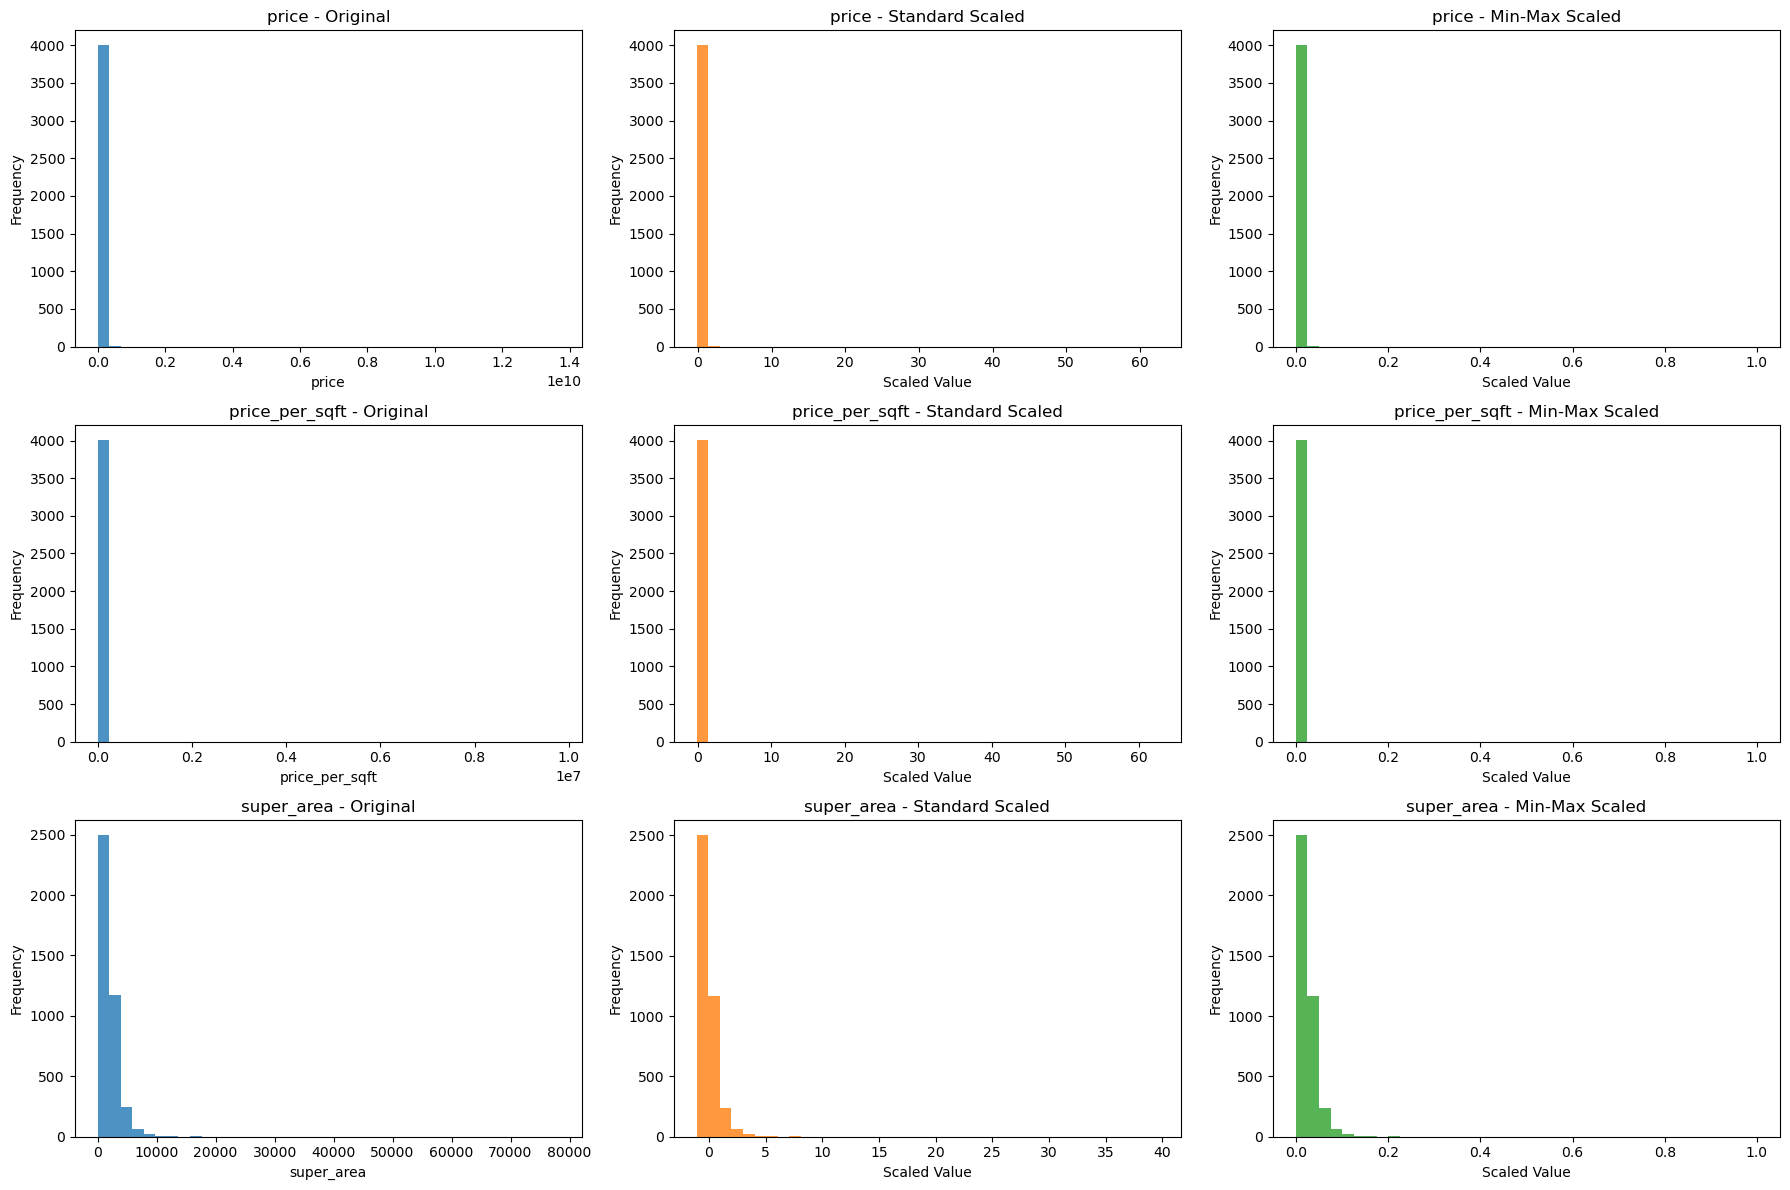

In [62]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

features = ['price', 'price_per_sqft', 'super_area']
nan_mask = df[features].isna()
filled_features = df[features].fillna(df[features].median())

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

standard_scaled = pd.DataFrame(
    standard_scaler.fit_transform(filled_features),
    columns=[f"{col}_standard_scaled" for col in features],
    index=df.index
)
minmax_scaled = pd.DataFrame(
    minmax_scaler.fit_transform(filled_features),
    columns=[f"{col}_minmax_scaled" for col in features],
    index=df.index
)

standard_scaled[nan_mask] = np.nan
minmax_scaled[nan_mask] = np.nan

df[standard_scaled.columns] = standard_scaled
df[minmax_scaled.columns] = minmax_scaled

fig, axes = plt.subplots(len(features), 3, figsize=(18, 4 * len(features)))
view_titles = ["Original", "Standard Scaled", "Min-Max Scaled"]

for row, feature in enumerate(features):
    axes[row, 0].hist(df[feature].dropna(), bins=40, color="#1f77b4", alpha=0.8)
    axes[row, 0].set_title(f"{feature} - {view_titles[0]}")
    axes[row, 0].set_xlabel(feature)
    axes[row, 0].set_ylabel("Frequency")

    axes[row, 1].hist(df[f"{feature}_standard_scaled"].dropna(), bins=40, color="#ff7f0e", alpha=0.8)
    axes[row, 1].set_title(f"{feature} - {view_titles[1]}")
    axes[row, 1].set_xlabel("Scaled Value")
    axes[row, 1].set_ylabel("Frequency")

    axes[row, 2].hist(df[f"{feature}_minmax_scaled"].dropna(), bins=40, color="#2ca02c", alpha=0.8)
    axes[row, 2].set_title(f"{feature} - {view_titles[2]}")
    axes[row, 2].set_xlabel("Scaled Value")
    axes[row, 2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [63]:
df.head()

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,transaction,furnishing_status,bathroom_count,...,dist_to_centre_km,dist_to_airport_km,dist_to_metro_km,accessibility_score,price_standard_scaled,price_per_sqft_standard_scaled,super_area_standard_scaled,price_minmax_scaled,price_per_sqft_minmax_scaled,super_area_minmax_scaled
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,Resale,Semi,9.0,...,6.55,34.00,1.26,0.2357,1.904745,0.127085,3.612578,0.032705,0.003515,0.114708
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,Resale,Semi,3.0,...,3.08,35.16,1.00,0.3036,0.082101,0.081227,-0.280521,0.003589,0.002784,0.018973
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,New Property,Unfurnished,2.0,...,18.82,54.14,40.00,0.0336,-0.062503,-0.014647,-0.313818,0.001279,0.001254,0.018154
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,New Property,Unfurnished,2.0,...,11.90,44.46,1.92,0.1724,-0.068452,-0.021572,-0.301332,0.001184,0.001144,0.018461
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,Resale,Semi,2.0,...,35.41,72.18,40.00,0.0235,-0.050605,0.008872,-0.398100,0.001469,0.001630,0.016082


In [64]:
df = df.iloc[:, :-3]
df.head()

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,transaction,furnishing_status,bathroom_count,...,latitude,longitude,locality,dist_to_centre_km,dist_to_airport_km,dist_to_metro_km,accessibility_score,price_standard_scaled,price_per_sqft_standard_scaled,super_area_standard_scaled
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,Resale,Semi,9.0,...,13.009859,77.553298,Rajajinagar,6.55,34.00,1.26,0.2357,1.904745,0.127085,3.612578
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,Resale,Semi,3.0,...,12.994880,77.556237,Prakash Nagar,3.08,35.16,1.00,0.3036,0.082101,0.081227,-0.280521
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,New Property,Unfurnished,2.0,...,12.899052,77.678117,Kasavanahalli,18.82,54.14,40.00,0.0336,-0.062503,-0.014647,-0.313818
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,New Property,Unfurnished,2.0,...,12.898554,77.565011,Vikram Nagar,11.90,44.46,1.92,0.1724,-0.068452,-0.021572,-0.301332
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,Resale,Semi,2.0,...,12.746104,77.487602,Kanakapura,35.41,72.18,40.00,0.0235,-0.050605,0.008872,-0.398100


In [65]:
#The accessibility score needs to be created again as the features need to be scaled first

distance_features = ['dist_to_centre_km', 'dist_to_airport_km', 'dist_to_metro_km']
distance_nan_mask = df[distance_features].isna()
filled_distances = df[distance_features].fillna(df[distance_features].median())

distance_scaler = StandardScaler()
scaled_distances = pd.DataFrame(
    distance_scaler.fit_transform(filled_distances),
    columns=distance_features,
    index=df.index
)

scaled_distances[distance_nan_mask] = np.nan
df[distance_features] = scaled_distances

In [66]:
df.head(10)


,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,transaction,furnishing_status,bathroom_count,...,latitude,longitude,locality,dist_to_centre_km,dist_to_airport_km,dist_to_metro_km,accessibility_score,price_standard_scaled,price_per_sqft_standard_scaled,super_area_standard_scaled
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,Resale,Semi,9.0,...,13.009859,77.553298,Rajajinagar,-0.216481,-0.211419,-1.117091,0.2357,1.904745,0.127085,3.612578
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,Resale,Semi,3.0,...,12.994880,77.556237,Prakash Nagar,-0.219898,-0.210266,-1.131402,0.3036,0.082101,0.081227,-0.280521
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,New Property,Unfurnished,2.0,...,12.899052,77.678117,Kasavanahalli,-0.204398,-0.191412,1.015215,0.0336,-0.062503,-0.014647,-0.313818
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,New Property,Unfurnished,2.0,...,12.898554,77.565011,Vikram Nagar,-0.211212,-0.201028,-1.080764,0.1724,-0.068452,-0.021572,-0.301332
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,Resale,Semi,2.0,...,12.746104,77.487602,Kanakapura,-0.188060,-0.173491,1.015215,0.0235,-0.050605,0.008872,-0.398100
5,6,"2 BHK Flat for Sale in Whitefield, Bangalore",26000000.0,17508.0,2.0,1485.0,15.0,Resale,Semi,2.0,...,12.968048,77.739097,Palm Meadows,-0.201768,-0.207058,-1.056546,0.1419,-0.027725,0.015432,-0.288325
6,7,"2 BHK Flat for Sale in Hennur Main Road, Bang...",14300000.0,11607.0,2.0,924.0,10.0,Resale,Semi,2.0,...,13.023166,77.630966,HBR Layout 2nd Block,-0.212660,-0.212094,1.015215,0.0506,-0.081264,-0.022373,-0.580191
7,8,"2 BHK Flat for Sale in Carmelaram, Bangalore",11500000.0,10952.0,2.0,811.0,6.0,Resale,Semi,2.0,...,12.902551,77.706854,Carmelaram,-0.202684,-0.189673,1.015215,0.0318,-0.094077,-0.026569,-0.638980
8,9,"2 BHK Flat for Sale in Tumkur Road, Bangalore",13500000.0,12442.0,2.0,762.0,22.0,Resale,Semi,2.0,...,13.158156,77.325762,Bengaluru,-0.187824,-0.185014,1.015215,0.0239,-0.084925,-0.017024,-0.664473
9,10,2 BHK Flat for Sale in Bannerghatta Main Road...,17000000.0,12593.0,2.0,1000.0,10.0,Resale,Semi,3.0,...,12.860841,77.591099,Gottigere,-0.192974,-0.197412,1.015215,0.0266,-0.068909,-0.016056,-0.540651


In [71]:
# Create accessibility_score with weighted sum of standardized distance features
# Since features are standardized: negative values = below average distance (higher accessibility)
#                                  positive values = above average distance (lower accessibility)
# Weights: centre=0.4, metro=0.4, airport=0.2 (centre and metro are more important for daily life)

def calculate_accessibility_score(row):
    centre_dist = row['dist_to_centre_km']
    metro_dist = row['dist_to_metro_km']
    airport_dist = row['dist_to_airport_km']
    
    # Handle missing values with median (which should be close to 0 for standardized data)
    if pd.isna(centre_dist):
        centre_dist = df['dist_to_centre_km'].median()
    if pd.isna(airport_dist):
        airport_dist = df['dist_to_airport_km'].median()
    if pd.isna(metro_dist):
        metro_dist = df['dist_to_metro_km'].median()
    
    # For standardized features, convert to accessibility scores
    # Negative standardized distance (below average) -> higher accessibility score
    # Positive standardized distance (above average) -> lower accessibility score
    # We'll use a sigmoid-like transformation: score = 1 / (1 + exp(distance))
    import math
    
    centre_score = 1 / (1 + math.exp(centre_dist))
    metro_score = 1 / (1 + math.exp(metro_dist))
    airport_score = 1 / (1 + math.exp(airport_dist))
    
    # Weighted sum (centre=0.4, metro=0.4, airport=0.2)
    accessibility_score = (0.4 * centre_score) + (0.4 * metro_score) + (0.2 * airport_score)
    
    return round(accessibility_score, 4)

# Apply the function to create the new feature
df['accessibility_score'] = df.apply(calculate_accessibility_score, axis=1)

print("Accessibility score statistics:")
print(df['accessibility_score'].describe())
print(f"\nAccessibility score range: {df['accessibility_score'].min()} to {df['accessibility_score'].max()}")

Accessibility score statistics:
count    4004.000000
mean        0.517558
std         0.122774
min         0.110700
25%         0.436500
50%         0.603700
75%         0.622600
max         0.637800
Name: accessibility_score, dtype: float64

Accessibility score range: 0.1107 to 0.6378


In [68]:
# Verify the accessibility score logic with some examples
print("Verification of accessibility score calculation:")
print("=" * 50)

# Show some examples of how standardized distances map to accessibility scores
sample_data = df[['dist_to_centre_km', 'dist_to_metro_km', 'dist_to_airport_km', 'accessibility_score']].head(10)
print("\nSample data showing standardized distances and accessibility scores:")
print(sample_data)

print(f"\nInterpretation:")
print(f"- Negative standardized distances (below average) → Higher accessibility scores")
print(f"- Positive standardized distances (above average) → Lower accessibility scores")
print(f"- Accessibility scores range from {df['accessibility_score'].min():.4f} to {df['accessibility_score'].max():.4f}")

# Show correlation between individual distance features and accessibility score
import pandas as pd
correlations = df[['dist_to_centre_km', 'dist_to_metro_km', 'dist_to_airport_km', 'accessibility_score']].corr()['accessibility_score']
print(f"\nCorrelations with accessibility_score:")
for feature in ['dist_to_centre_km', 'dist_to_metro_km', 'dist_to_airport_km']:
    print(f"{feature}: {correlations[feature]:.4f}")
print("(All correlations should be negative, indicating that higher distances → lower accessibility)")

Verification of accessibility score calculation:

Sample data showing standardized distances and accessibility scores:
   dist_to_centre_km  dist_to_metro_km  dist_to_airport_km  \
0          -0.216481         -1.117091           -0.211419   
1          -0.219898         -1.131402           -0.210266   
2          -0.204398          1.015215           -0.191412   
3          -0.211212         -1.080764           -0.201028   
4          -0.188060          1.015215           -0.173491   
5          -0.201768         -1.056546           -0.207058   
6          -0.212660          1.015215           -0.212094   
7          -0.202684          1.015215           -0.189673   
8          -0.187824          1.015215           -0.185014   
9          -0.192974          1.015215           -0.197412   

   accessibility_score  
0               0.6335  
1               0.6348  
2               0.4363  
3               0.6297  
4               0.4338  
5               0.6272  
6               0.4381 

In [73]:
df.head()

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,transaction,furnishing_status,bathroom_count,...,latitude,longitude,locality,dist_to_centre_km,dist_to_airport_km,dist_to_metro_km,accessibility_score,price_standard_scaled,price_per_sqft_standard_scaled,super_area_standard_scaled
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,Resale,Semi,9.0,...,13.009859,77.553298,Rajajinagar,-0.216481,-0.211419,-1.117091,0.6335,1.904745,0.127085,3.612578
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,Resale,Semi,3.0,...,12.994880,77.556237,Prakash Nagar,-0.219898,-0.210266,-1.131402,0.6348,0.082101,0.081227,-0.280521
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,New Property,Unfurnished,2.0,...,12.899052,77.678117,Kasavanahalli,-0.204398,-0.191412,1.015215,0.4363,-0.062503,-0.014647,-0.313818
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,New Property,Unfurnished,2.0,...,12.898554,77.565011,Vikram Nagar,-0.211212,-0.201028,-1.080764,0.6297,-0.068452,-0.021572,-0.301332
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,Resale,Semi,2.0,...,12.746104,77.487602,Kanakapura,-0.188060,-0.173491,1.015215,0.4338,-0.050605,0.008872,-0.398100


In [ ]:
#Checkpoint
df.to_csv('../data/temp_gold1.csv', index=False)

In [75]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical features to encode
categorical_features = ['transaction', 'furnishing_status']

# Initialize OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the categorical features
encoded_features = ohe.fit_transform(df[categorical_features])

# Create DataFrame with encoded features
encoded_df = pd.DataFrame(
    encoded_features,
    columns=ohe.get_feature_names_out(categorical_features),
    index=df.index
)

# Add encoded features to the main DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop original categorical columns
df = df.drop(columns=categorical_features)

print("Encoded features added:")
print(encoded_df.columns.tolist())
print(f"\nDataFrame shape after encoding: {df.shape}")
print(f"\nNew columns in DataFrame:")
for col in encoded_df.columns:
    print(f"- {col}")
    

Encoded features added:
['transaction_Resale', 'furnishing_status_Semi', 'furnishing_status_Unfurnished']

DataFrame shape after encoding: (4004, 22)

New columns in DataFrame:
- transaction_Resale
- furnishing_status_Semi
- furnishing_status_Unfurnished


In [76]:
df.head()

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,bathroom_count,property_type,latitude,...,dist_to_centre_km,dist_to_airport_km,dist_to_metro_km,accessibility_score,price_standard_scaled,price_per_sqft_standard_scaled,super_area_standard_scaled,transaction_Resale,furnishing_status_Semi,furnishing_status_Unfurnished
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,9.0,apartment,13.009859,...,-0.216481,-0.211419,-1.117091,0.6335,1.904745,0.127085,3.612578,1.0,1.0,0.0
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,3.0,apartment,12.994880,...,-0.219898,-0.210266,-1.131402,0.6348,0.082101,0.081227,-0.280521,1.0,1.0,0.0
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,2.0,apartment,12.899052,...,-0.204398,-0.191412,1.015215,0.4363,-0.062503,-0.014647,-0.313818,0.0,0.0,1.0
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,2.0,apartment,12.898554,...,-0.211212,-0.201028,-1.080764,0.6297,-0.068452,-0.021572,-0.301332,0.0,0.0,1.0
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,2.0,apartment,12.746104,...,-0.188060,-0.173491,1.015215,0.4338,-0.050605,0.008872,-0.398100,1.0,1.0,0.0


In [77]:
df['locality'].value_counts()

locality
Palm Meadows           193
Bengaluru              187
Kaikondrahalli         174
BSF Campus              67
Patel Layout            59
                      ... 
Kempapura                1
Dhanalakshmi Layout      1
Doddathathamangala       1
Dandupalya               1
AMS Layout               1
Name: count, Length: 919, dtype: int64

In [78]:
df['locality'].isnull().sum()

158

In [79]:
df['locality'] = df['locality'].fillna('Bengaluru')

In [80]:
df['locality'].value_counts()

locality
Bengaluru              345
Palm Meadows           193
Kaikondrahalli         174
BSF Campus              67
Patel Layout            59
                      ... 
Kempapura                1
Dhanalakshmi Layout      1
Doddathathamangala       1
Dandupalya               1
AMS Layout               1
Name: count, Length: 919, dtype: int64

In [81]:
df['locality'].nunique()

919

In [82]:
from sklearn.preprocessing import LabelEncoder

# Approach 1: Frequency/Target Encoding (Recommended for ML)

# Get locality frequency counts
locality_freq = df['locality'].value_counts()

# Create frequency encoding
df['locality_frequency'] = df['locality'].map(locality_freq)

# Keep only top N localities, group rest as 'Other'
top_n = 50  # Adjust based on your needs
top_localities = locality_freq.head(top_n).index
df['locality_grouped'] = df['locality'].apply(lambda x: x if x in top_localities else 'Other')

# One-hot encode the grouped localities
locality_encoded = pd.get_dummies(df['locality_grouped'], prefix='locality', drop_first=True)
df = pd.concat([df, locality_encoded], axis=1)

# Drop original locality columns
df = df.drop(columns=['locality', 'locality_grouped'])

print(f"Reduced from 919 to {len(locality_encoded.columns)} locality features")
print(f"Top {top_n} localities capture {(locality_freq.head(top_n).sum() / len(df) * 100):.1f}% of data")

Reduced from 919 to 50 locality features
Top 50 localities capture 47.2% of data


In [83]:
df.head()

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,bathroom_count,property_type,latitude,...,locality_Phase III,locality_Pragathi Nagar,locality_Prakash Nagar,locality_Prakruthi Nagar,locality_Royal Enclave,locality_Saint Thomas Town,locality_Shivananada Layout,locality_Veer Sandra,locality_Vinayaka Nagar,locality_Yeshwanthpur Industrial Area
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,9.0,apartment,13.009859,...,False,False,False,False,False,False,False,False,False,False
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,3.0,apartment,12.994880,...,False,False,True,False,False,False,False,False,False,False
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,2.0,apartment,12.899052,...,False,False,False,False,False,False,False,False,False,False
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,2.0,apartment,12.898554,...,False,False,False,False,False,False,False,False,False,False
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,2.0,apartment,12.746104,...,False,False,False,False,False,False,False,False,False,False


In [85]:
len(df.columns)

72

In [86]:
#As we are training tree based models we can keep the price related features as it is.

# Drop scaled features since we're using tree-based models
scaled_columns = [col for col in df.columns if 'scaled' in col]
df = df.drop(columns=scaled_columns)

print(f"Dropped {len(scaled_columns)} scaled features:")
for col in scaled_columns:
    print(f"- {col}")
    
print(f"\nDataFrame shape after dropping scaled features: {df.shape}")

Dropped 3 scaled features:
- price_standard_scaled
- price_per_sqft_standard_scaled
- super_area_standard_scaled

DataFrame shape after dropping scaled features: (4004, 69)


In [90]:
df['super_area'] = df['super_area'].fillna(df['super_area'].median())

In [91]:
df.isnull().sum().sum()

363

In [93]:
df = df.dropna(subset=['latitude'])

In [94]:
df.isnull().sum().sum()

45

In [95]:
df['bathroom_count'] = df['bathroom_count'].fillna(df['bhk_count'])

In [96]:
df.isnull().sum().sum()

6

In [97]:
df.columns[df.isnull().sum() > 0]

Index(['dist_to_centre_km', 'dist_to_airport_km'], dtype='object')

In [98]:
df['dist_to_airport_km'].isnull().sum()

3

In [99]:
removed_rows = df['dist_to_airport_km'].isna().sum()
if removed_rows:
    df = df[df['dist_to_airport_km'].notna()].copy()
print(f"Removed {removed_rows} rows with null dist_to_airport_km.")

Removed 3 rows with null dist_to_airport_km.


In [100]:
df.isnull().sum().sum()

0

In [101]:
df.head()

,property_id,title,price,price_per_sqft,bhk_count,super_area,floor,bathroom_count,property_type,latitude,...,locality_Phase III,locality_Pragathi Nagar,locality_Prakash Nagar,locality_Prakruthi Nagar,locality_Royal Enclave,locality_Saint Thomas Town,locality_Shivananada Layout,locality_Veer Sandra,locality_Vinayaka Nagar,locality_Yeshwanthpur Industrial Area
0,1,"8 BHK Flat for Sale in Rajajinagar, Bangalore",448300000.0,34936.0,8.0,8983.0,2.0,9.0,apartment,13.009859,...,False,False,False,False,False,False,False,False,False,False
1,2,"2 BHK Flat for Sale in Rajajinagar, Bangalore",50000000.0,27778.0,2.0,1500.0,16.0,3.0,apartment,12.994880,...,False,False,True,False,False,False,False,False,False,False
2,3,"2 BHK Flat for Sale in Sarjapur Road, Bangalore",18400000.0,12813.0,2.0,1436.0,1.0,2.0,apartment,12.899052,...,False,False,False,False,False,False,False,False,False,False
3,4,"2 BHK Flat for Sale in Kanakapura Road, Banga...",17100000.0,11732.0,2.0,1460.0,1.0,2.0,apartment,12.898554,...,False,False,False,False,False,False,False,False,False,False
4,5,"2 BHK Flat for Sale in Kanakapura Road, Banga...",21000000.0,16484.0,2.0,1274.0,21.0,2.0,apartment,12.746104,...,False,False,False,False,False,False,False,False,False,False


In [102]:
df.to_csv('../data/gold-houseprices.csv', index=False)